In [1]:
import fenics as dl
import numpy as np
import matplotlib.pyplot as plt
from hippylib import nb
from hippylib import CGSolverSteihaug
import ufl

In [2]:
plt.style.use('classic')
plt.rcParams.update({'font.size': 16})

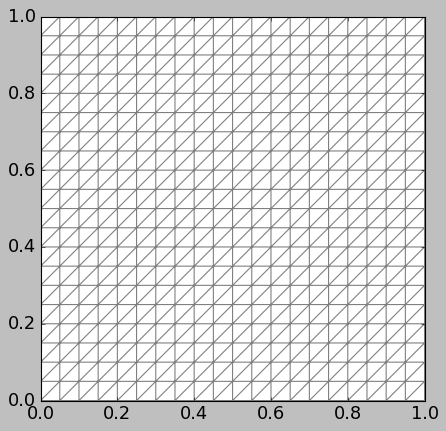

In [3]:
nx = 20
ny = 20
mesh = dl.UnitSquareMesh(nx, ny)
dl.plot(mesh)
plt.show()

Vh = dl.FunctionSpace(mesh, "CG", 1)

### Here we seek to solve the advection diffusion problem in FEniCS

We seek $u(t,x)$ such that
\begin{align}
\frac{\partial u}{\partial t} - \kappa\Delta u+v^{\top}\nabla u&= 0 \quad \text{ on }\left[0,T\right]\times\Omega\\
\frac{\partial u}{\partial n}&=0\quad \text{ in }\left[0,T\right]\times\partial\Omega\\
u(x,0)&=m(x)\quad \text{ in }\Omega\cup\partial\Omega
\end{align}

In [4]:
v = dl.Constant((0.5, -0.25)) # advection field
kappa = 0.05                  # diffusion constant
T  = 0.25                     # final time

### Define the true parameter field as a Gaussian centered at $(0.5, 0.5)$

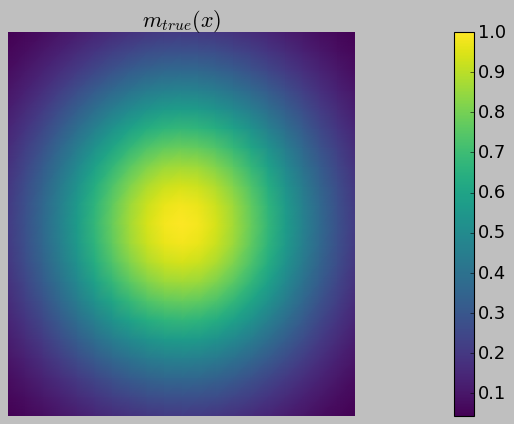

In [5]:
sig = 0.4
mtrue = dl.interpolate(dl.Expression('std::exp(-1.0*(pow(x[0]-0.5, 2) + pow(x[1]-0.5,2))/pow(sig, 2))', \
                                  element=Vh.ufl_element(), sig=sig), Vh)
nb.plot(mtrue, mytitle=r"$m_{true}(x)$")
plt.show()

### Define the advection, diffusion and mass forms, compute finite-element representations of said operators and backward-Euler time advancement operators

In [6]:
class reducedHessian:
    def __init__(me, Vh, simulation_times, kappa, v, T1, gamma1, gamma2):
        me.nt = len(simulation_times)
        me.dt = simulation_times[1] - simulation_times[0]
        me.Vh = Vh
        me.simulation_times = simulation_times
        me.T1 = T1
        me.gamma1 = gamma1
        me.gamma2 = gamma2
        me.kappa = kappa
        me.v     = v
        utest = dl.TestFunction(Vh)
        utrial = dl.TrialFunction(Vh)
        Kform  = dl.inner(dl.grad(utest), dl.grad(utrial))*dl.dx(me.Vh.mesh())
        Mform  = utest*utrial*dl.dx(me.Vh.mesh())
        Bform  = utest*dl.inner(me.v, dl.grad(utrial))*dl.dx(me.Vh.mesh())
        BTform = utrial*dl.inner(me.v, dl.grad(utest))*dl.dx(me.Vh.mesh())
        Rform  = (gamma1*utest*utrial + gamma2*dl.inner(dl.grad(utest), dl.grad(utrial)))*dl.dx(me.Vh.mesh())
        
        
        me.K = dl.assemble(Kform)
        me.M = dl.assemble(Mform)
        me.B = dl.assemble(Bform)
        me.BT = dl.assemble(BTform)
        me.R     = dl.assemble(Rform)
        
     
        me.A     = me.M + me.dt*(me.kappa*me.K + me.B)
        me.A_adj = me.M + me.dt*(me.kappa*me.K + me.BT)
        me.ud = None
    def solve_fwd(me, m):
        u = [dl.Function(me.Vh) for i in range(me.nt)]
        u[0].assign(m)
        solver = dl.LUSolver()
        solver.set_operator(me.A)
        rhs = dl.Vector()
        me.A.init_vector(rhs, 0)
        for i in range(1, me.nt):
            rhs = me.M * u[i-1].vector()
            solver.solve(u[i].vector(), rhs)
        return u
    def solve_adj(me, u):
        p = [dl.Function(me.Vh) for i in range(me.nt)]
        rhs1 = dl.Vector()
        rhs2 = dl.Vector()
        me.M.init_vector(rhs1, 0)
        me.M.init_vector(rhs2, 0)
        solver = dl.LUSolver()
        solver.set_operator(me.A_adj)
        for i in range(nt-1, 0, -1):
            if i < nt-1:
                rhs1 = me.M * p[i+1].vector()
            if me.simulation_times[i] > me.T1:
                rhs2 = me.M * (u[i].vector() - me.ud[i].vector())
                rhs1.axpy(-1.*me.dt, rhs2)
            solver.solve(p[i].vector(), rhs1)
        p[0].vector().set_local(me.M * p[1].vector())
        return p
    def cost(me, m):
        u = me.solve_fwd(m)
        misfit = 0.
        data_discrepancy = dl.Function(me.Vh)
        for i, t in enumerate(me.simulation_times):
            if t > me.T1:
                data_discrepancy.assign(u[i])
                data_discrepancy.vector().axpy(-1.0, me.ud[i].vector())
                misfit += 0.5*me.dt*dl.norm(data_discrepancy, 'L2')**2.
        reg = 0.5*m.vector().inner(me.R * m.vector())
        return [misfit+reg, misfit, reg]
    def grad(me, m):
        u = me.solve_fwd(m)
        p = me.solve_adj(u)
        MG = dl.Vector()
        me.M.init_vector(MG, 0)
        MG.axpy(1.0, me.R * m.vector())
        MG.axpy(-1.0, p[0].vector())
        return MG
    def solve_incfwd(me, mhat):
        uhat = [dl.Function(me.Vh) for i in range(me.nt)]
        uhat[0].assign(mhat)
        solver = dl.LUSolver()
        solver.set_operator(me.A)
        rhs = dl.Vector()
        me.A.init_vector(rhs, 0)
        for i in range(1, me.nt):
            rhs = me.M * uhat[i-1].vector()
            solver.solve(uhat[i].vector(), rhs)
        return uhat
    def solve_incadj(me, uhat):
        phat = [dl.Function(me.Vh) for i in range(me.nt)]
        rhs1 = dl.Vector()
        rhs2 = dl.Vector()
        me.M.init_vector(rhs1, 0)
        me.M.init_vector(rhs2, 0)
        solver = dl.LUSolver()
        solver.set_operator(me.A_adj)
        for i in range(nt-1, 0, -1):
            if i < nt-1:
                rhs1 = me.M * phat[i+1].vector()
            if me.simulation_times[i] > me.T1:
                rhs2 = me.M * uhat[i].vector()
                rhs1.axpy(-1.*me.dt, rhs2)
            solver.solve(phat[i].vector(), rhs1)
        phat[0].vector().set_local(me.M * phat[1].vector())
        return phat
    def init_vector(me, x, j):
        me.M.init_vector(x, j)
    def mult(me, x, y):
        mhat = dl.Function(me.Vh)
        mhat.vector().zero()
        mhat.vector().axpy(1.0, x)
        uhat = me.solve_incfwd(mhat)
        phat = me.solve_incadj(uhat)
        y.zero()
        y.axpy(1.0, me.R * x)
        y.axpy(-1.0, phat[0].vector())
        

In [7]:
nt = 100
simulation_times = np.linspace(0., T, num=nt)
T1    = 0.8*T
gamma1 = 1.e-10
gamma2 = 1.e-6
hess  = reducedHessian(Vh, simulation_times, kappa, v, T1, gamma1, gamma2)

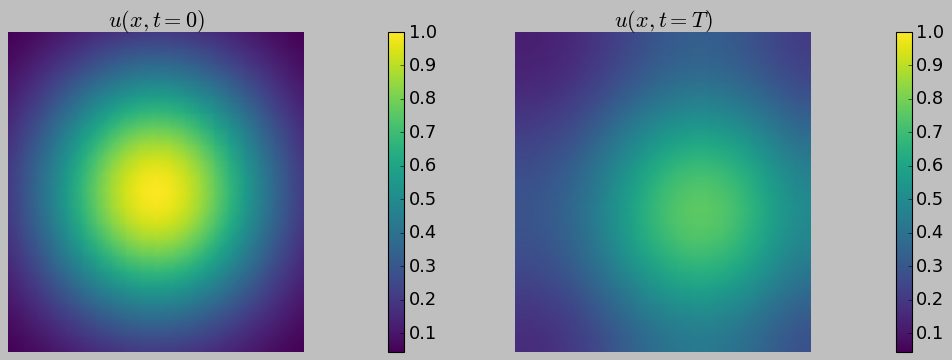

In [8]:
u = hess.solve_fwd(mtrue)
nb.multi1_plot([u[0], u[-1]], [r"$u(x, t=0)$", r"$u(x, t=T)$"])
plt.show()

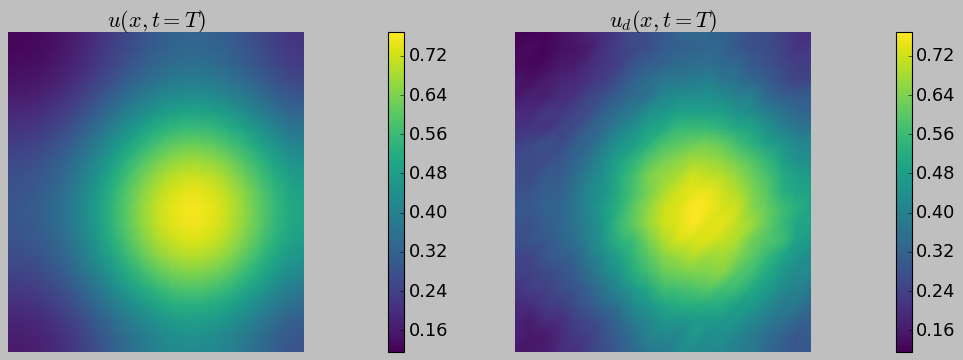

In [9]:
ud = [dl.Function(Vh) for i in range(nt)]

noise_lvl = 0.02
for i in range(nt):
    ud[i].assign(u[i])
    uL2 = dl.norm(u[i], 'L2')
    noise = noise_lvl * uL2 *np.random.randn(Vh.dim()) 
    ud[i].vector().vec()[:] += noise

nb.multi1_plot([u[-1], ud[-1]], [r"$u(x, t=T)$", r"$u_{d}(x, t=T)$"])
plt.show()


hess.ud = ud

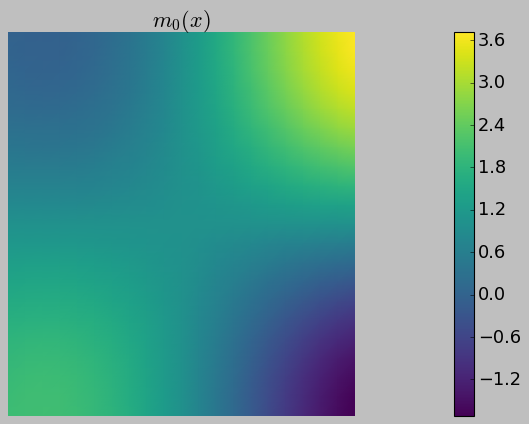

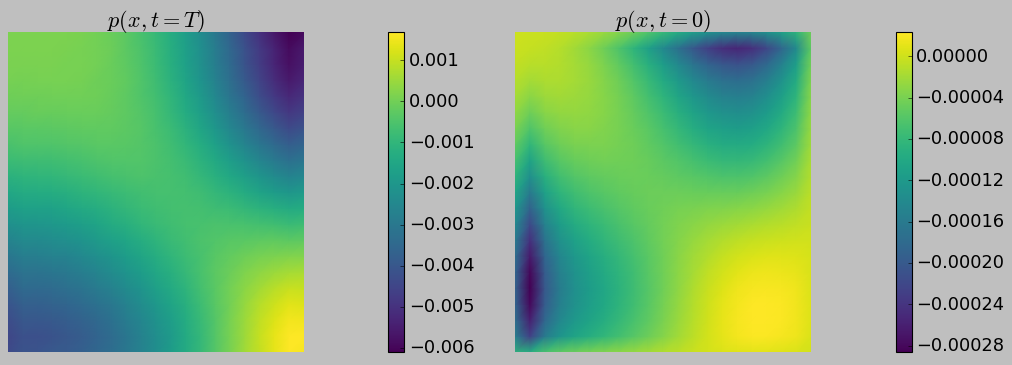

In [10]:
m0 = dl.interpolate(dl.Expression('1.+std::exp(x[0])*std::cos(pi*x[0])*std::cos(pi*x[1])', \
                                  element=Vh.ufl_element(), pi=np.pi), Vh) 

nb.plot(m0, mytitle=r"$m_{0}(x)$")
plt.show()
u0 = hess.solve_fwd(m0)
p0 = hess.solve_adj(u0)

nb.multi1_plot([p0[-1], p0[0]], [r"$p(x, t=T)$", r"$p(x, t=0)$"], same_colorbar=False)
plt.show()


In [11]:
mdir = dl.interpolate(dl.Expression('std::cos(2.*x[0]*pi)', \
                                   element=Vh.ufl_element(), pi=np.pi), Vh)

J0 = hess.cost(m0)[0]

grad0 = hess.grad(m0)

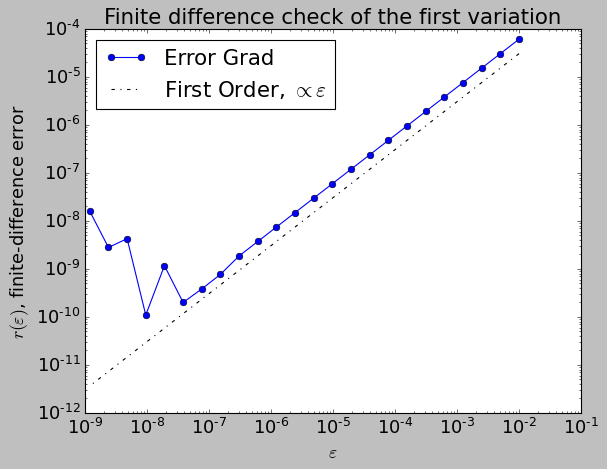

In [12]:
n_eps = 24
eps = 1e-2*np.power(2., -np.arange(n_eps))
err_grad = np.zeros(n_eps)

mh   = dl.Function(Vh)
mhat = dl.Function(Vh).vector()
mhat.set_local(mdir.vector().get_local())

dir_grad0 = grad0.inner(mhat)


for i in range(n_eps):
    mh.assign(m0)
    mh.vector().axpy(eps[i], mhat) #uh = uh + eps[i]*dir
    Jplus = hess.cost(mh)[0]
    err_grad[i] = abs( (Jplus - J0)/eps[i] - dir_grad0 )

plt.figure()    
plt.loglog(eps, err_grad, "-ob", label="Error Grad")
plt.loglog(eps, (.5*err_grad[0]/eps[0])*eps, "-.k", label=r"First Order, $\propto\varepsilon$")
plt.title("Finite difference check of the first variation")
plt.xlabel(r"$\varepsilon$")
plt.ylabel(r"$r(\varepsilon)$, finite-difference error")
plt.legend(loc = "upper left")
plt.show()

 Iterartion :  0  (B r, r) =  8604652.82302734
 Iteration :  1  (B r, r) =  29.976599817414666
 Iteration :  2  (B r, r) =  8.470804662086225
 Iteration :  3  (B r, r) =  0.5647337256384596
 Iteration :  4  (B r, r) =  78.71458484649555
 Iteration :  5  (B r, r) =  0.470704698088713
 Iteration :  6  (B r, r) =  0.034927428346374925
 Iteration :  7  (B r, r) =  649.4489935751632
 Iteration :  8  (B r, r) =  0.004970135232403488
 Iteration :  9  (B r, r) =  0.003566887409968149
 Iteration :  10  (B r, r) =  0.04920897199288342
 Iteration :  11  (B r, r) =  0.00013892842808242494
 Iteration :  12  (B r, r) =  0.00017954799497464454
 Iteration :  13  (B r, r) =  0.00017576098871599933
 Iteration :  14  (B r, r) =  4.299859886164107e-05
 Iteration :  15  (B r, r) =  2.5223031596899754e-05
 Iteration :  16  (B r, r) =  0.00760204574363788
 Iteration :  17  (B r, r) =  5.540616904511348e-06
 Iteration :  18  (B r, r) =  7.094271643466627e-05
 Iteration :  19  (B r, r) =  4.962095851184509e-05

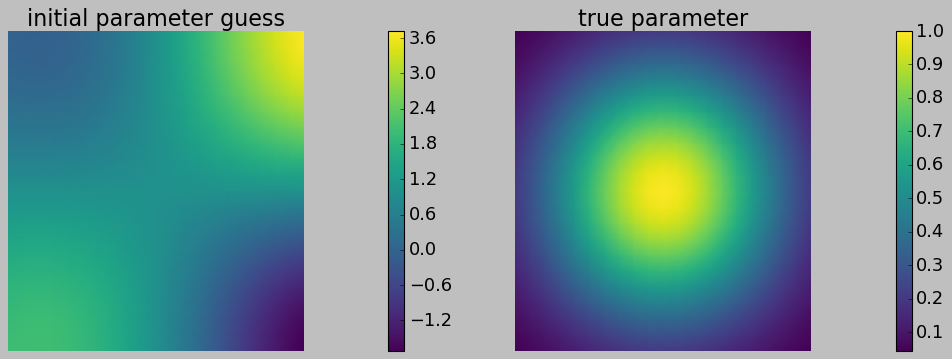

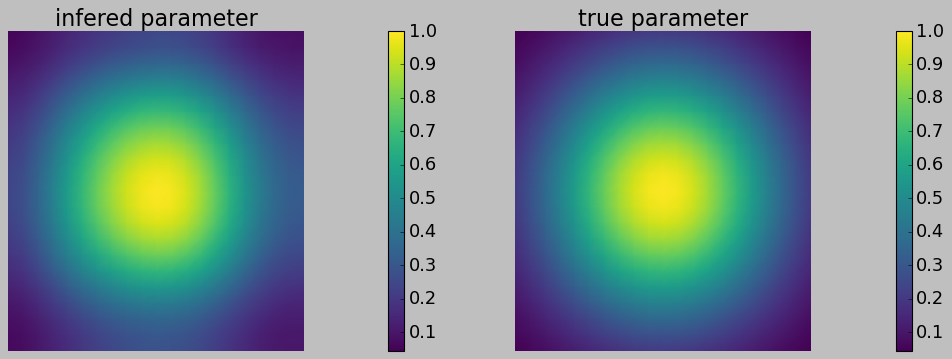

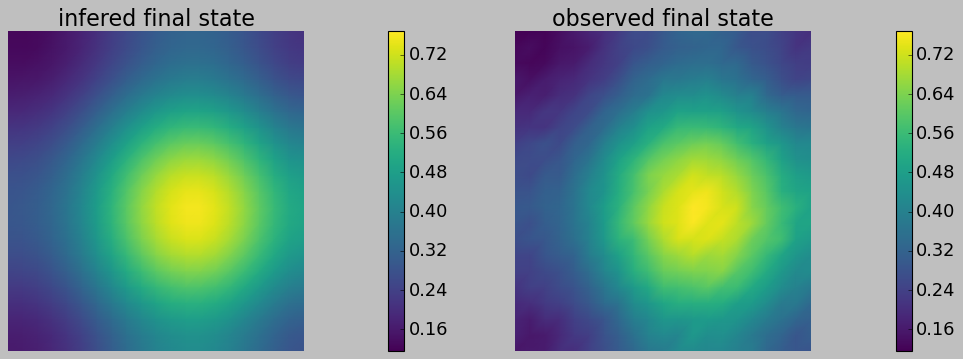

In [13]:
mh.assign(m0)
g = hess.grad(m0)


solver = CGSolverSteihaug()
solver.set_operator(hess)
precond_solver = dl.LUSolver()
precond_solver.set_operator(hess.R)
solver.set_preconditioner(precond_solver)
solver.parameters["print_level"]= 1
solver.solve(mh.vector(), -1.*g)

mh.vector().axpy(1.0, m0.vector())
nb.multi1_plot([m0, mtrue], ["initial parameter guess", "true parameter"], same_colorbar=False)
plt.show()
nb.multi1_plot([mh, mtrue], ["infered parameter", "true parameter"])
plt.show()


uh = hess.solve_fwd(mh)

nb.multi1_plot([uh[-1], ud[-1]], ["infered final state", "observed final state"])



Nit   cost      misfit     reg       ||grad||/||grad_0||   alpha     N backtrack


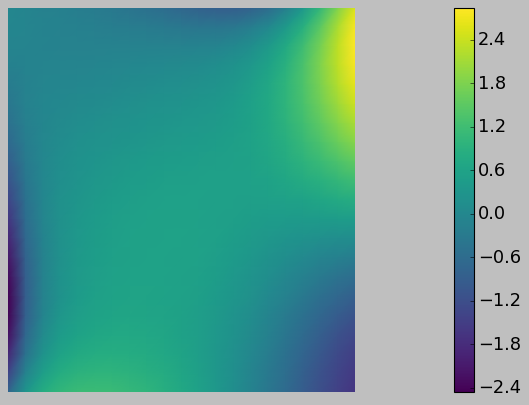

 10   3.38e-05   2.35e-05   1.04e-05   7.98e-03          1.22e+01   13
 20   1.37e-05   7.78e-06   5.97e-06   1.79e-02          2.44e+01   12
 30   6.76e-06   2.92e-06   3.84e-06   9.04e-03          2.44e+01   12
 40   4.48e-06   1.74e-06   2.74e-06   4.64e-03          3.91e+02    8
 50   3.31e-06   1.29e-06   2.02e-06   2.38e-03          1.95e+02    9


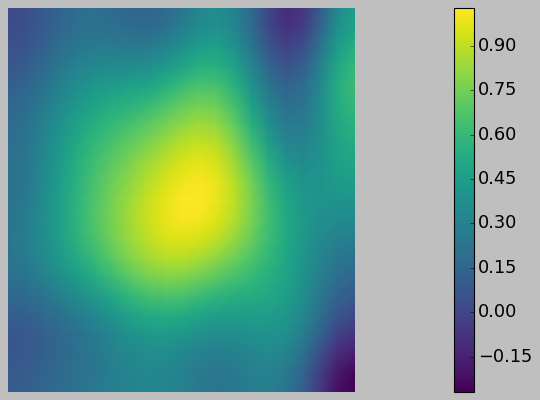

 60   3.22e-06   1.29e-06   1.93e-06   3.33e-03          2.44e+01   12
 70   2.64e-06   1.11e-06   1.53e-06   2.00e-03          2.44e+01   12
 80   2.55e-06   1.09e-06   1.46e-06   1.71e-03          2.44e+01   12
 90   2.42e-06   1.04e-06   1.38e-06   8.57e-04          2.44e+01   12
100   2.42e-06   1.05e-06   1.37e-06   1.25e-03          2.44e+01   12


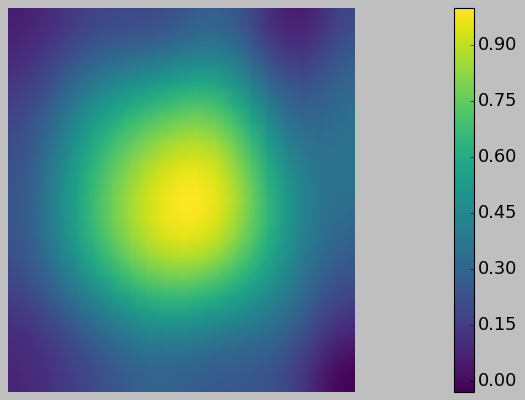

110   2.35e-06   1.03e-06   1.32e-06   7.45e-04          2.44e+01   12
120   2.33e-06   1.02e-06   1.31e-06   3.73e-04          2.44e+01   12
130   2.32e-06   1.02e-06   1.31e-06   7.16e-05          1.22e+01   13
140   2.31e-06   1.02e-06   1.30e-06   3.25e-04          2.44e+01   12
150   2.31e-06   1.01e-06   1.30e-06   3.76e-05          1.22e+01   13


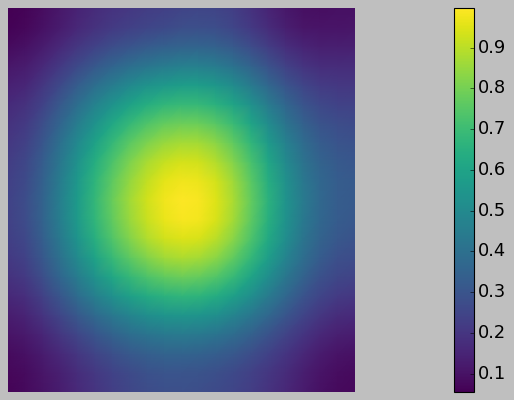

160   2.31e-06   1.01e-06   1.29e-06   1.40e-04          2.44e+01   12
170   2.31e-06   1.01e-06   1.29e-06   2.06e-05          1.22e+01   13
180   2.31e-06   1.01e-06   1.29e-06   1.57e-05          1.22e+01   13
190   2.31e-06   1.01e-06   1.29e-06   6.08e-05          2.44e+01   12
Steepest descent converged in  199   iterations


In [14]:
cost_old = hess.cost(m0)[0]

# define parameters for the optimization
tol = 1.e-5
maxiter = 1000
print_every = 10
plot_every = 50
c_armijo = 1e-4

# initialize iter counters
it = 0
converged = False

# initializations
g = dl.Vector()
hess.M.init_vector(g,0)

m_prev = dl.Function(Vh)
mh.assign(m0)


print( "Nit   cost      misfit     reg       ||grad||/||grad_0||   alpha     N backtrack" )

while it <  maxiter and not converged:
    MG = hess.grad(mh)
    dl.solve(hess.M, g, MG)

    # calculate the norm of the gradient
    grad_norm2 = g.inner(MG)
    gradnorm = np.sqrt(grad_norm2)
    
    if it == 0:
        gradnorm0 = gradnorm
    if it > 0 and it % print_every == 0:
        print("%3d   %1.2e   %1.2e   %1.2e   %1.2e          %1.2e   %2d" \
              %(it, cost_old, misfit_old, reg_old, gradnorm/gradnorm0, alpha, it_backtrack))

    # linesearch
    it_backtrack = 0
    m_prev.assign(mh) # save mh, to reference later
    alpha = 1.e5
    backtrack_converged = False
    for it_backtrack in range(20):
        
        mh.vector().axpy(-alpha, g )

        # evaluate cost
        [cost_new, misfit_new, reg_new] = hess.cost(mh)

        # check if Armijo conditions are satisfied
        if cost_new < cost_old - alpha * c_armijo * grad_norm2:
            cost_old = cost_new
            misfit_old = misfit_new
            reg_old    = reg_new
            backtrack_converged = True
            break
        else:
            alpha *= 0.5
            mh.assign(m_prev)  # reset m
            
            
    if backtrack_converged == False:
        print( "Backtracking failed. A sufficient descent direction was not found" )
        converged = False
        break
    if it % plot_every == 0:
        nb.plot(mh)
        plt.show()
   
    # check for convergence
    if gradnorm < tol*gradnorm0 and it > 0:
        converged = True
        print ("Steepest descent converged in ", it,"  iterations")
        
    it += 1
    
if not converged:
    print ( "Steepest descent did not converge in ", maxiter, " iterations")